# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (urti), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [15]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
import io
import sys
from contextlib import redirect_stdout
# import miceforest as mf
%matplotlib inline

In [16]:
#os.chdir("..")
current_working_dir = os.getcwd()
# print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

In [17]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [18]:
# def makeFilePath(pathFromWorkspace, fileName):
#     workingdir = "/workspace/" if (os.name != "nt") else ""
#     filepath = workingdir+pathFromWorkspace+fileName

#     return filepath

In [19]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [20]:
# def create_lineplot(data, var, title, legend_title, ax1):
#     a = data.groupby(['date', var]).size().reset_index()
#     a.columns = ['date', var, 'Freq']
#     sns.lineplot(x='date', y='Freq', 
#             hue=var, 
#             data=a,
#             ax=ax1)
#     ax1.set_title(title)
#     ax1.set_ylabel('Frequency')
#     ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
# #     ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
# #     ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
# #     ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [21]:
# def create_lineplot_hue(var, hue, title, legend_title, ax1):
#     a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
#     a.columns = ['date', var, hue, 'Freq']
#     a = a[a[var] != 0]
#     sns.lineplot(x='date', y='Freq', 
#             hue=hue, 
#             data=a,
#             ax=ax1)
#     ax1.set_title(title)
#     ax1.set_ylabel('Frequency')
#     ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
#     ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
#     ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [22]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

## 1- Data Preparation

In [23]:
# data2019_month = {}
# data2020_month = {}
# data2021_month = {}
# data2019 = []
# data2020 = []
# data2021 = []
# for  i in range(1, 13):
#     # data of 2019
#     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
#     data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
#     data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
#     if (i<3) or (i>11):
#         data2019_month["%s" %i]['season'] = "Winter"
#     elif (i>2) and (i<6):
#         data2019_month["%s" %i]['season'] = "Spring"
#     elif (i>5) and (i<9):
#         data2019_month["%s" %i]['season'] = "Summer"
#     elif (i>8) and (i<12):
#         data2019_month["%s" %i]['season'] = "Autumn"
#     data2019.append(data2019_month["%s" %i])
#     # data of 2020
#     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
#     data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
#     data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
#     if (i<3) or (i>11):
#         data2020_month["%s" %i]['season'] = "Winter"
#     elif (i>2) and (i<6):
#         data2020_month["%s" %i]['season'] = "Spring"
#     elif (i>5) and (i<9):
#         data2020_month["%s" %i]['season'] = "Summer"
#     elif (i>8) and (i<12):
#         data2020_month["%s" %i]['season'] = "Autumn"
#     data2020.append(data2020_month["%s" %i])
#     # data of 2021
#     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
#     data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
#     data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
#     if (i<3) or (i>11):
#         data2021_month["%s" %i]['season'] = "Winter"
#     elif (i>2) and (i<6):
#         data2021_month["%s" %i]['season'] = "Spring"
#     elif (i>5) and (i<9):
#         data2021_month["%s" %i]['season'] = "Summer"
#     elif (i>8) and (i<12):
#         data2021_month["%s" %i]['season'] = "Autumn"
#     data2021.append(data2021_month["%s" %i])
    
# data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
# data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
# data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

# data = data2019.append([data2020, data2021], ignore_index=True)

In [24]:
# data2019_month = {}
# # data2020_month = {}
# # data2021_month = {}
# # data2022_month = {}
# data2019 = []
# # data2020 = []
# # data2021 = []
# # data2022 = []
# i=1
# while  i < 13:
#     # data of 2019
#     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
#     data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
#     data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
#     if (i<3) or (i>11):
#         data2019_month["%s" %i]['season'] = "Winter"
#     elif (i>2) and (i<6):
#         data2019_month["%s" %i]['season'] = "Spring"
#     elif (i>5) and (i<9):
#         data2019_month["%s" %i]['season'] = "Summer"
#     elif (i>8) and (i<12):
#         data2019_month["%s" %i]['season'] = "Autumn"
#     data2019.append(data2019_month["%s" %i])
#     i=i+1
    
# # i=1
# # while  i < 13:    
# #     # data of 2020
# #     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
# #     data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
# #     data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
# #     if (i<3) or (i>11):
# #         data2020_month["%s" %i]['season'] = "Winter"
# #     elif (i>2) and (i<6):
# #         data2020_month["%s" %i]['season'] = "Spring"
# #     elif (i>5) and (i<9):
# #         data2020_month["%s" %i]['season'] = "Summer"
# #     elif (i>8) and (i<12):
# #         data2020_month["%s" %i]['season'] = "Autumn"
# #     data2020.append(data2020_month["%s" %i])
# #     i=i+1

# # i=1
# # while  i < 13:
# #     # data of 2021
# #     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
# #     data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
# #     data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
# #     if (i<3) or (i>11):
# #         data2021_month["%s" %i]['season'] = "Winter"
# #     elif (i>2) and (i<6):
# #         data2021_month["%s" %i]['season'] = "Spring"
# #     elif (i>5) and (i<9):
# #         data2021_month["%s" %i]['season'] = "Summer"
# #     elif (i>8) and (i<12):
# #         data2021_month["%s" %i]['season'] = "Autumn"
# #     data2021.append(data2021_month["%s" %i])
# #     i=i+1

# # i=1
# # while  i < 4:
# #     # data of 2022
# #     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2022-"+str(i).zfill(2)+"-01.csv.gz")
# #     data2022_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
# #     data2022_month["%s" %i]['date'] = "2022-"+str(i).zfill(2)
# #     if (i<3) or (i>11):
# #         data2022_month["%s" %i]['season'] = "Winter"
# #     elif (i>2) and (i<6):
# #         data2022_month["%s" %i]['season'] = "Spring"
# #     elif (i>5) and (i<9):
# #         data2022_month["%s" %i]['season'] = "Summer"
# #     elif (i>8) and (i<12):
# #         data2022_month["%s" %i]['season'] = "Autumn"
# #     data2022.append(data2022_month["%s" %i])
# #     i=i+1
    
# data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
# # data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
# # data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)
# # data2022 = pd.concat(data2022_month, axis=0, ignore_index=True)

# # data = data2019.append([data2020, data2021, data2022], ignore_index=True)

# data = data2019

In [26]:
# data2019_month = {}
# data2019 = []

# i=1
# while  i < 13:
#     # data of 2019
#     # if (i<4):
#     data2019_month["%s" %i] = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_2019-'+str(i).zfill(2)+'-01.csv.gz')
#     data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
#     # if (i>3) and (i<7):
#     #     data2019_month["%s" %i] = pd.read_csv(f'output/hospitalisation_data/input_hospitalisatio2019-'+str(i).zfill(2)+'-01.csv.gz')
#     #     data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
#     if (i<3) or (i>11):
#         data2019_month["%s" %i]['season'] = "Winter"
#     elif (i>2) and (i<6):
#         data2019_month["%s" %i]['season'] = "Spring"
#     elif (i>5) and (i<9):
#         data2019_month["%s" %i]['season'] = "Summer"
#     elif (i>8) and (i<12):
#         data2019_month["%s" %i]['season'] = "Autumn"

#     data2019.append(data2019_month["%s" %i])
#     i=i+1
    
# data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)

# data = data2019

In [27]:
data201901 = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_2019-01-01.csv.gz')
# data201901['date'] = "2019-01"
# data201901['season'] = "Winter"
# data201902 = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_2019-02-01.csv.gz')
# data201902['date'] = "2019-02"
# data201902['season'] = "Winter"
# data201903 = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_2019-03-01.csv.gz')
# data201903['date'] = "2019-03"
# data201903['season'] = "Spring"

In [28]:
# data2019 = [data201901, data201902, data201903]
# data = pd.concat(data2019)

In [ ]:
data = data201901

In [29]:
# data = data.loc[data['sex'] == 'F']
# data.shape

In [31]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,primary_care_covid,admitted_date,deregistered_date,died_date,...,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date,season
count,22500,3000,3000,3000,3000,3000,3000,9000,1500,3000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000,30000
unique,40,40,40,13,13,1103,1102,1194,864,454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2
top,2021-05,2021-05,2020-08,2018-09,2018-05,2020-08-11,2020-07-19,2021-10-31,2020-08-31,2022-03-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01,Winter
freq,618,98,88,268,281,8,9,16,6,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,20000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,49801.081133,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300005,0.300005,0.300005,0.300005,0.300005,0.300005,0.300005,28743.364416,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25055.500000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49573.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74407.000000,NaN,NaN


#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [38]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

# ## remove died cases
# #data.died_date.value_counts()

# # remove cases with bmi equal 0
# data['bmi'][data['bmi'] <= 0] = 0

# # remove cases with negative gp_count
# data['gp_count'][data['gp_count'] < 0] = np.nan

# # remove cases with negative antibacterial_brit
# data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [ ]:
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

In [48]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

#### URTI-1

In [49]:
data_urti_1 = data[['Age_cat', #'msoa', #'date', 
                #     'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                #    'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                #    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', #'season', 
                   'died_date', 'deregistered_date', 
                    'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1',
                    'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(312, 31)

In [50]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(282, 31)

In [51]:
data_urti_1.columns

Index(['date', 'Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp',
       'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine',
       'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI',
       'died_date', 'deregistered_date', 'season', 'meds_nonabs',
       'gp_cons_urti_1', 'gp_cons_urti_ab_1', 'urti_date_1',
       'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1'],
      dtype='object')

#### URTI-2

In [52]:
data_urti_2 = data[['Age_cat', #'msoa', #'date',
                #     'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                #    'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                #    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs',  #'season',
                   'died_date', 'deregistered_date', 
                    'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2',
                    'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(319, 31)

In [53]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(289, 31)

In [54]:
data_urti_2.columns

Index(['date', 'Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp',
       'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine',
       'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI',
       'died_date', 'deregistered_date', 'season', 'meds_nonabs',
       'gp_cons_urti_2', 'gp_cons_urti_ab_2', 'urti_date_2',
       'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2'],
      dtype='object')

#### URTI_3

In [55]:
data_urti_3 = data[['Age_cat', #'msoa', #'date',
                #     'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                #    'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                #    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs',  #'season',
                   'died_date', 'deregistered_date', 
                    'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3',
                    'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(299, 31)

In [56]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(277, 31)

In [57]:
data_urti_3.columns

Index(['date', 'Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp',
       'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine',
       'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI',
       'died_date', 'deregistered_date', 'season', 'meds_nonabs',
       'gp_cons_urti_3', 'gp_cons_urti_ab_3', 'urti_date_3',
       'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3'],
      dtype='object')

#### URTI_4

In [58]:
data_urti_4 = data[['Age_cat', #'msoa', #'date',
                #     'age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine', 
                #    'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp',
                #    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs',  #'season',
                   'died_date', 'deregistered_date', 
                   'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                   'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4',
                   'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(299, 31)

In [59]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(262, 31)

In [60]:
data_urti_4.columns

Index(['date', 'Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp',
       'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine',
       'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI',
       'died_date', 'deregistered_date', 'season', 'meds_nonabs',
       'gp_cons_urti_4', 'gp_cons_urti_ab_4', 'urti_date_4',
       'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4'],
      dtype='object')

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [61]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date', 'incdt_urti_date_1': 'incdt_urti_date', 
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date', 'incdt_urti_date_2': 'incdt_urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date', 'incdt_urti_date_3': 'incdt_urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 'incdt_urti_date_4': 'incdt_urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(1110, 31)

In [33]:
# fig, axes = plt.subplots(7,2,
#                         figsize=(15, 33)
#                         )
# create_lineplot(data_urti, 'sex', 'Sex', 'Sex', axes[0,0])
# create_lineplot(data_urti, 'Age_cat', 'Age category', 'Age category', axes[0,1])
# create_lineplot(data_urti, 'imd_imp', 'IMD', 'IMD', axes[1,0])
# create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
# create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
# create_lineplot(data_urti, 'BMI_cat', 'BMI', 'BMI', axes[2,1])
# create_lineplot(data_urti, 'CCI_cat', 'CCI', 'CCI', axes[3,0])
# create_lineplot(data_urti, 'gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
# create_lineplot(data_urti, 'region', 'Region', 'Region', axes[4,0])
# create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
# create_lineplot(data_urti, 'antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'msoa', 'msoa', 'MSOA', axes[5,1])
# create_lineplot(data_urti, 'meds_nonabs', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[6,0])
# fig.delaxes(ax=axes[6,1])

# fig.suptitle('Risk Factors of URTI patients', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
# plt.show()

#### Adding event and duration columns

In [65]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(1110, 31)

In [66]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0

In [67]:
#scenario 2
# become a case (uncensoring)
#calculating days between infection dx and hosp
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 130)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    772
1.0     43
Name: event_urti_admitted, dtype: int64

In [68]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

1004.0    4
883.0     3
721.0     3
227.0     2
660.0     2
         ..
870.0     1
1130.0    1
35.0      1
514.0     1
620.0     1
Name: delta_urti_admitted, Length: 299, dtype: int64

In [69]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_urti.loc[data_urti['delta_admitted_died'] > 0, 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    802
1.0     38
Name: event_urti_admitted, dtype: int64

In [70]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] < 130)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    803
1.0     38
Name: event_urti_admitted, dtype: int64

In [71]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

1074

In [72]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [73]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    1071
1.0      38
Name: event_urti_admitted, dtype: int64

In [74]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 130)
data_urti.loc[(data_urti['duration_urti_admitted'] > 130), 'duration_urti_admitted'] = 130
data_urti['duration_urti_admitted'].value_counts()

130.0    1065
31.0        2
3.0         2
73.0        2
33.0        2
93.0        1
112.0       1
12.0        1
128.0       1
91.0        1
101.0       1
0.0         1
76.0        1
55.0        1
67.0        1
2.0         1
126.0       1
94.0        1
77.0        1
95.0        1
75.0        1
110.0       1
87.0        1
88.0        1
115.0       1
98.0        1
64.0        1
74.0        1
57.0        1
62.0        1
83.0        1
41.0        1
17.0        1
66.0        1
129.0       1
11.0        1
28.0        1
119.0       1
35.0        1
106.0       1
36.0        1
Name: duration_urti_admitted, dtype: int64

In [75]:
data_urti[data_urti['duration_urti_admitted']<0][['delta_urti_admitted', 'urti_date', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,duration_urti_admitted


In [76]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 130)), 'event_urti_admitted'] = 1

#### Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [77]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# # with antibiotics and incident hospital admission
# data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
# data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# # no antibiotics and prevalent hospital admission
# data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
# data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# # with antibiotics and prevalent hospital admission
# data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
# data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
# print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
# print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
# print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (893, 37)
shape of data_urti_abs_incdt: (118, 37)
shape of data_urti_no_abs_prevl: (86, 37)
shape of data_urti_abs_prevl: (12, 37)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [78]:
data_urti_no_abs_incdt.columns

Index(['date', 'Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp',
       'BMI_cat', 'gp_count', 'gp_count_cat', 'gp_count_imp', 'flu_vaccine',
       'region', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'hx_hosp', 'CCI_cat', 'CCI',
       'died_date', 'deregistered_date', 'season', 'meds_nonabs',
       'gp_cons_urti', 'gp_cons_urti_ab', 'urti_date', 'incdt_urti_date',
       'admitted_urti_date', 'sgss_gp_cov_urti_date', 'event_urti_admitted',
       'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [79]:
data_urti_no_abs_incdt.shape

(893, 37)

In [80]:
#keep relevant variables
# data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count_imp', 'flu_vaccine',
#                                                'region', 'antibacterial_brit_imp', 'imd_imp', 'ethnicity_imp', 'CCI_cat', 'CCI',
#                                                'event_urti_admitted', 'duration_urti_admitted']]

data_urti_no_abs_incdt = data_urti_no_abs_incdt[['Age_cat',
                                                #  'age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', #'season', 
                                                #  'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
                                                #  'meds_nonabs',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [81]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age                       0
bmi_imp                   0
gp_count_imp              0
flu_vaccine               0
sex                       0
region                    0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
smoking_status_imp        0
meds_nonabs               0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [82]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [83]:
data_urti_no_abs_incdt.columns

Index(['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region',
       'season', 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp',
       'smoking_status_imp', 'meds_nonabs', 'event_urti_admitted',
       'duration_urti_admitted'],
      dtype='object')

In [84]:
fold_thre = len(data_urti_no_abs_incdt)-round(len(data_urti_no_abs_incdt)/4)
data_urti_no_abs_incdt_train = data_urti_no_abs_incdt.iloc[:fold_thre]
data_urti_no_abs_incdt_test = data_urti_no_abs_incdt.iloc[fold_thre:]

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (670, 14)
shape of data_urti_no_abs_incdt for testing: (223, 14)


In [85]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="Age_cat"
        # "age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # + season
        )
cph_urti_no_abs_incdt.print_summary()
# cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 670 total observations, 642 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 670
number of events observed = 28
   partial log-likelihood = -167.78
         time fit was run = 2022-03-23 18:36:52 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
age                                  0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
antibacterial_brit_imp              -0.02       0.98       0.14            -0.29             0.25                 0.75                 1.28
bmi_imp                             -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
ethnicity_imp[T.Mixed]               0.23       1.26       1.10            -1.93             2.40                 0.14                10.98
ethnicity_imp[T.Other]             -17.39       0.00    5933.69        -11647.22         11612.44                 0.00                  inf
ethnicity_imp[T.White]               0.95       2.58       1.03            -1.08             2.98                 0.34                19.63
flu_vaccine[T.Yes]                  -1.18       0.31       1.03            -3.19             0.84                 0.04                 2.32
gp_count_imp                         0.03       1.03       0.05            -0.07             0.14                 0.93                 1.15
imd_imp                              0.09       1.10       0.14            -0.19             0.37                 0.83                 1.45
meds_nonabs                         -0.11       0.89       0.14            -0.38             0.16                 0.68                 1.17
region[T.East Midlands]            -18.49       0.00    4656.40         -9144.86          9107.88                 0.00                  inf
region[T.London]                    -1.27       0.28       0.74            -2.72             0.18                 0.07                 1.20
region[T.North East]                -0.62       0.54       0.69            -1.97             0.72                 0.14                 2.05
region[T.North West]                -0.73       0.48       0.84            -2.38             0.93                 0.09                 2.53
region[T.South East]                -0.53       0.59       0.74            -1.98             0.92                 0.14                 2.52
region[T.South West]                -0.08       0.92       0.64            -1.34             1.18                 0.26                 3.24
region[T.West Midlands]             -0.01       0.99       0.65            -1.28             1.26                 0.28                 3.53
region[T.Yorkshire and The Humber]  -1.66       0.19       1.10            -3.82             0.50                 0.02                 1.64
season[T.Spring]                    -0.23       0.79       0.55            -1.31             0.84                 0.27                 2.32
season[T.Summer]                    -0.06       0.94       0.53            -1.11             0.98                 0.33                 2.67
season[T.Winter]                    -0.13       0.87       0.54            -1.19             0.93                 0.30                 2.52
sex[T.Male]                          0.00       1.00       0.39            -0.76             0.77                 0.47                 2.15
smoking_status_imp[T.Never smoked]  -1.14       0.32       1.04            -3.18             0.91                 0.04                 2.48
smoking_status_imp[T.Smoker]         0.18       1.20       0.39            -0.59             0.95               

In [166]:
output = GetPrintSummary(cph_urti_no_abs_incdt)

with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_incdt_summary.html', "w") as fo:
    print(fo.write(output))
    fo.close()

8141


In [ ]:
a = cph_urti_no_abs_incdt.baseline_hazard_
# cph_urti_no_abs_incdt.baseline_survival_
# cph_urti_no_abs_incdt.predict_cumulative_hazard(data_urti_no_abs_incdt, data_urti_no_abs_incdt['duration_urti_admitted']<=30)
# cph_urti_no_abs_incdt.predict_survival_function(data_urti_no_abs_incdt)

# save 
np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_incdt.txt', a, delimiter=',')

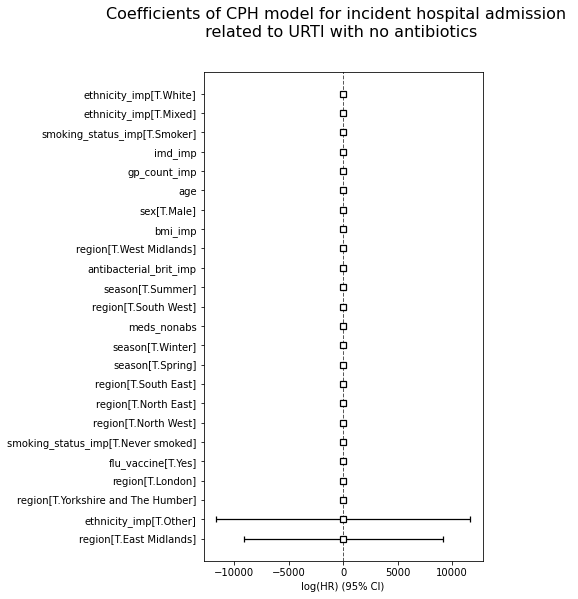

In [86]:
fig, ax = plt.subplots(figsize=(5, 9)
                        )
cph_urti_no_abs_incdt.plot()
plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with no antibiotics', fontsize=16)
#_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
#                        rotation=45, fontsize=12, ha='right')
plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
plt.show()

In [168]:
# concordance index of cph model with testing data
concord_index_urti_no_abs_incdt_test = concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted'])
print(f'Concordance index for urti_no_abs_incdt with testing data: {concord_index_urti_no_abs_incdt_test}')
# print(concordance_index(data_urti_no_abs_incdt_test['event_urti_admitted'], -cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt_test), data_urti_no_abs_incdt_test['duration_urti_admitted']))

Concordance index for uti_no_abs_incdt with testing data: 0.5150943396226415


In [169]:
# a = [concord_index_urti_no_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_incdt_test.txt', a, delimiter=',')

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

# # t0 (float) – the time to evaluate the probability of event occurring prior at.
# # ICI – mean absolute difference between predicted and observed
# # E50 – median absolute difference between predicted and observed

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_incdt, data_urti_no_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [29]:
# cph_urti_no_abs_incdt_predicted = cph_urti_no_abs_incdt.predict_partial_hazard(data_urti_no_abs_incdt)

# fig, ax = plt.subplots(figsize=(8, 5))
# fig = sm.qqplot(cph_urti_no_abs_incdt_predicted, line='45', ax=ax)
# plt.suptitle('Q-Q plot for calibration of CPH model for incident hospital \n admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/qq_calibration_cph_urti_no_abs_incdt.jpg', bbox_inches='tight')
# # pylab.show()
# plt.show()

In [174]:
# print(cph_urti_no_abs_incdt.score(data_urti_no_abs_incdt_1_test))
# print(cph_urti_no_abs_incdt.concordance_index_)
# print(cph_urti_no_abs_incdt.AIC_partial_)
# print(cph_urti_no_abs_incdt.concordance_index_)

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [4]:
# data_urti_abs_incdt.columns

In [3]:
# data_urti_abs_incdt.shape

In [89]:
# #keep relevant variables
# data_urti_abs_incdt = data_urti_abs_incdt[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', #'season', 
#                                          'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
#                                          'meds_nonabs',
#                                          'event_urti_admitted', 'duration_urti_admitted']]

In [2]:
# # printing number of missing values in each variable 
# data_urti_abs_incdt.isnull().sum()

In [91]:
# #drop ros with missing values
# data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
# #data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
# data_urti_abs_incdt.isnull().sum()

In [1]:
# fold_thre = len(data_urti_abs_incdt)-round(len(data_urti_abs_incdt)/4)
# data_urti_abs_incdt_train = data_urti_abs_incdt.iloc[:fold_thre]
# data_urti_abs_incdt_test = data_urti_abs_incdt.iloc[fold_thre:]

# print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
# print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

In [5]:
# cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_abs_incdt.print_summary()

In [94]:
# output = GetPrintSummary(cph_urti_abs_incdt)

# with open('../output/hospitalisation_prediction_urti/cph_urti_abs_incdt_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

8608


In [ ]:
# a = cph_urti_abs_incdt.baseline_hazard_
# # cph_urti_abs_incdt.baseline_survival_
# # cph_urti_abs_incdt.predict_cumulative_hazard(data_urti_abs_incdt, data_urti_abs_incdt['duration_urti_admitted']<=30)
# # cph_urti_abs_incdt.predict_survival_function(data_urti_abs_incdt)

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_abs_incdt.txt', a, delimiter=',')

In [6]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_abs_incdt.plot()
# plt.suptitle('Coefficients of CPH model for incident hospital admission \n related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_abs_incdt.jpg', bbox_inches='tight')
# plt.show()

In [7]:
# # concordance index of cph model with testing data
# concord_index_urti_abs_incdt_test = concordance_index(data_urti_abs_incdt_test['event_urti_admitted'], -cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt_test), data_urti_abs_incdt_test['duration_urti_admitted'])
# print(f'Concordance index for urti_abs_incdt with testing data: {concord_index_urti_abs_incdt_test}')

In [8]:
# a = [concord_index_urti_abs_incdt_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_abs_incdt_test.txt', a, delimiter=',')

In [9]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_train, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_train.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_abs_incdt, data_urti_abs_incdt_test, t0=30)
# # plt.suptitle('Calibration of CPH model for incident hospital admission related to urti with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_abs_incdt_test.jpg', bbox_inches='tight')
# plt.show()

In [28]:
# cph_urti_abs_incdt_predicted = cph_urti_abs_incdt.predict_partial_hazard(data_urti_abs_incdt)

# fig, ax = plt.subplots(figsize=(8, 5))
# fig = sm.qqplot(cph_urti_abs_incdt_predicted, line='45', ax=ax)
# plt.suptitle('Q-Q plot for calibration of CPH model for incident hospital \n admission related to URTI with antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/qq_calibration_cph_urti_abs_incdt.jpg', bbox_inches='tight')
# # pylab.show()
# plt.show()

#### 4-1-3- Prevalent hospital admission related to URTI with no antibiotics

In [10]:
# data_urti_no_abs_prevl.columns

In [11]:
# data_urti_no_abs_prevl.shape

In [12]:
# #keep relevant variables
# data_urti_no_abs_prevl = data_urti_no_abs_prevl[['age', 'bmi_imp', 'gp_count_imp', 'flu_vaccine', 'sex', 'region', #'season', 
#                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'smoking_status_imp',
#                                                 'meds_nonabs',
#                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [13]:
# # printing number of missing values in each variable 
# data_urti_no_abs_prevl.isnull().sum()

In [98]:
# #drop rows with missing values
# data_urti_no_abs_prevl = data_urti_no_abs_prevl.dropna(axis='rows')
# #data_urti_no_abs_prevl = data_urti_no_abs_prevl.drop(columns=['smoking_status'])
# data_urti_no_abs_prevl.isnull().sum()

In [14]:
# data_urti_no_abs_prevl.shape

In [15]:
# fold_thre = len(data_urti_no_abs_prevl)-round(len(data_urti_no_abs_prevl)/4)
# data_urti_no_abs_prevl_train = data_urti_no_abs_prevl.iloc[:fold_thre]
# data_urti_no_abs_prevl_test = data_urti_no_abs_prevl.iloc[fold_thre:]

# print(f'shape of data_urti_no_abs_prevl for training: {data_urti_no_abs_prevl_train.shape}')
# print(f'shape of data_urti_no_abs_prevl for testing: {data_urti_no_abs_prevl_test.shape}')

In [16]:
# cph_urti_no_abs_prevl = CoxPHFitter().fit(data_urti_no_abs_prevl_train,
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age + sex + bmi_imp + gp_count_imp + flu_vaccine + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
#         )
# cph_urti_no_abs_prevl.print_summary()

In [17]:
# output = GetPrintSummary(cph_urti_no_abs_prevl)

# with open('../output/hospitalisation_prediction_urti/cph_urti_no_abs_prevl_summary.html', "w") as fo:
#     print(fo.write(output))
#     fo.close()

In [18]:
# a = cph_urti_no_abs_prevl.baseline_hazard_
# # cph_urti_no_abs_prevl.baseline_survival_
# # cph_urti_no_abs_prevl.predict_cumulative_hazard(data_urti_no_abs_prevl, data_urti_no_abs_prevl['duration_urti_admitted']<=30)
# # cph_urti_no_abs_prevl.predict_survival_function(data_urti_no_abs_prevl)

# # save 
# np.savetxt('../output/hospitalisation_prediction_urti/sum_betas_urti_no_abs_prevl.txt', a, delimiter=',')

In [19]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_no_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission \n related to URTI with no antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# plt.savefig('../output/hospitalisation_prediction_urti/coefficients_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [20]:
# data_urti_no_abs_prevl_test.columns

In [21]:
# # concordance index of cph model with testing data
# concord_index_urti_no_abs_prevl_test = concordance_index(data_urti_no_abs_prevl_test['event_urti_admitted'], -cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl_test), data_urti_no_abs_prevl_test['duration_urti_admitted'])
# print(f'Concordance index for cph_urti_no_abs_prevl with testing data: {concord_index_urti_no_abs_prevl_test}')

In [22]:
# a = [concord_index_urti_no_abs_prevl_test]
# np.savetxt('../output/hospitalisation_prediction_urti/concord_index_urti_no_abs_prevl_test.txt', a, delimiter=',')

In [23]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_train, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_train.jpg', bbox_inches='tight')
# plt.show()

In [24]:
# fig, ax = plt.subplots(figsize=(8, 5)
#                         )
# survival_probability_calibration(cph_urti_no_abs_prevl, data_urti_no_abs_prevl_test, t0=30)
# plt.suptitle('Calibration of CPH model for prevalent hospital admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/calibration_cph_urti_no_abs_prevl_test.jpg', bbox_inches='tight')
# plt.show()

In [ ]:
# cph_urti_no_abs_prevl_predicted = cph_urti_no_abs_prevl.predict_partial_hazard(data_urti_no_abs_prevl)

# fig, ax = plt.subplots(figsize=(8, 5))
# fig = sm.qqplot(cph_urti_no_abs_prevl_predicted, line='45', ax=ax)
# plt.suptitle('Q-Q plot for calibration of CPH model for prevalent hospital \n admission related to URTI with no antibiotics', fontsize=16)
# plt.savefig('../output/hospitalisation_prediction_urti/qq_calibration_cph_urti_no_abs_prevl.jpg', bbox_inches='tight')
# # pylab.show()
# plt.show()

#### 4-1-4- Prevalent hospital admission related to URTI with antibiotics

In [385]:
# data_urti_abs_prevl.columns

In [386]:
# #keep relevant variables
# data_urti_abs_prevl = data_urti_abs_prevl[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine',
#                                         'region', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI',
#                                         'event_urti_admitted', 'duration_urti_admitted']]

In [387]:
# # print number of missing values in each variable 
# data_urti_abs_prevl.isnull().sum()

In [388]:
# #drop ros with missing values
# data_urti_abs_prevl = data_urti_abs_prevl.dropna(axis='rows')
# #data_urti_abs_prevl = data_urti_abs_prevl.drop(columns=['smoking_status'])
# data_urti_abs_prevl.isnull().sum()

In [389]:
# cph_urti_abs_prevl = CoxPHFitter(penalizer=0.1)
# cph_urti_abs_prevl.fit(data_urti_abs_prevl, 
#         duration_col='duration_urti_admitted',
#         event_col='event_urti_admitted',
#         formula="age_cat + sex + gp_count + flu_vaccine + region + antibacterial_brit + imd + ethnicity"
#         )
# cph_urti_abs_prevl.print_summary()

In [390]:
# fig, ax = plt.subplots(figsize=(5, 9)
#                         )
# cph_urti_abs_prevl.plot()
# plt.suptitle('Coefficients of CPH model for prevalent hospital admission related to URTI with antibiotics', fontsize=16)
# #_ = ax.set_yticklabels(['Age', 'BMI', 'GP consultations', 'CCI', 'IMD', 'Flu vaccine', 'Antibacterial prescriptions'], 
# #                        rotation=45, fontsize=12, ha='right')
# #plt.savefig('output/repeat_ABs_outputs/coefficients_cph_urti_abs_prevl.jpg', bbox_inches='tight')
# plt.show()

In [129]:
##save cph model with pickle package

# current_working_dir = os.getcwd()
# print(current_working_dir)

# with open('output/hospitalisation_prediction_urti/cph_urti_abs_prevl.pickle', 'wb') as f:
#     pickle.dump(cph_urti_abs_prevl, f)

# with open('output/hospitalisation_prediction_urti/cph_urti_abs_prevl.pickle', 'rb') as f:
#     cph_urti_abs_prevl = pickle.load(f)

# cph_urti_abs_prevl.summary

In [147]:
# hosp history, ab type history, 